In [1]:
import pandas as pd
from datetime import datetime
import numpy as np

# Load data
df = pd.read_csv('appData10.csv')

# Convert date columns
df['first_open'] = pd.to_datetime(df['first_open'])
df['enrolled_date'] = pd.to_datetime(df['enrolled_date'])

# Calculate cutoff date
cutoff_date = max(df['first_open'].max(), df['enrolled_date'].max())

# Create 'days_active' feature
df['days_active'] = df.apply(lambda x: (x['enrolled_date'] - x['first_open']).days 
                             if x['enrolled'] == 1 
                             else (cutoff_date - x['first_open']).days, axis=1)

# Drop columns
df.drop(['user', 'screen_list', 'first_open', 'enrolled_date'], axis=1, inplace=True)

In [2]:
df.head()

,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked,days_active
0,3,02:00:00,23,15,0,0,0,0,194
1,6,01:00:00,24,13,0,0,0,0,219
2,1,19:00:00,23,3,0,1,0,1,111
3,4,16:00:00,28,40,0,0,1,0,0
4,1,18:00:00,31,32,0,0,1,1,0


In [3]:
# Remove leading/trailing whitespace
df['hour'] = df['hour'].str.strip()

# Convert 'hour' from '%H:%M:%S' format to datetime, then extract the hour
df['hour'] = pd.to_datetime(df['hour'], format='%H:%M:%S', errors='coerce').dt.hour

# Now apply cyclical encoding
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

In [4]:
df['dayofweek'] = pd.to_numeric(df['dayofweek'], errors='coerce')
# Cyclical encoding for dayofweek
df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

# Drop original columns
df.drop(['dayofweek', 'hour'], axis=1, inplace=True)

In [5]:
df.head()

,age,numscreens,minigame,used_premium_feature,enrolled,liked,days_active,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos
0,23,15,0,0,0,0,194,0.500000,8.660254e-01,0.433884,-0.900969
1,24,13,0,0,0,0,219,0.258819,9.659258e-01,-0.781831,0.623490
2,23,3,0,1,0,1,111,-0.965926,2.588190e-01,0.781831,0.623490
3,28,40,0,0,1,0,0,-0.866025,-5.000000e-01,-0.433884,-0.900969
4,31,32,0,0,1,1,0,-1.000000,-1.836970e-16,0.781831,0.623490


In [6]:
print("\nMissing Values after cleaning:\n", df.isnull().sum())


Missing Values after cleaning:
 age                     0
numscreens              0
minigame                0
used_premium_feature    0
enrolled                0
liked                   0
days_active             0
hour_sin                0
hour_cos                0
dayofweek_sin           0
dayofweek_cos           0
dtype: int64


In [7]:
# Interaction: age * numscreens
df['age_numscreens'] = df['age'] * df['numscreens']

# Polynomial feature for age
df['age_squared'] = df['age'] ** 2

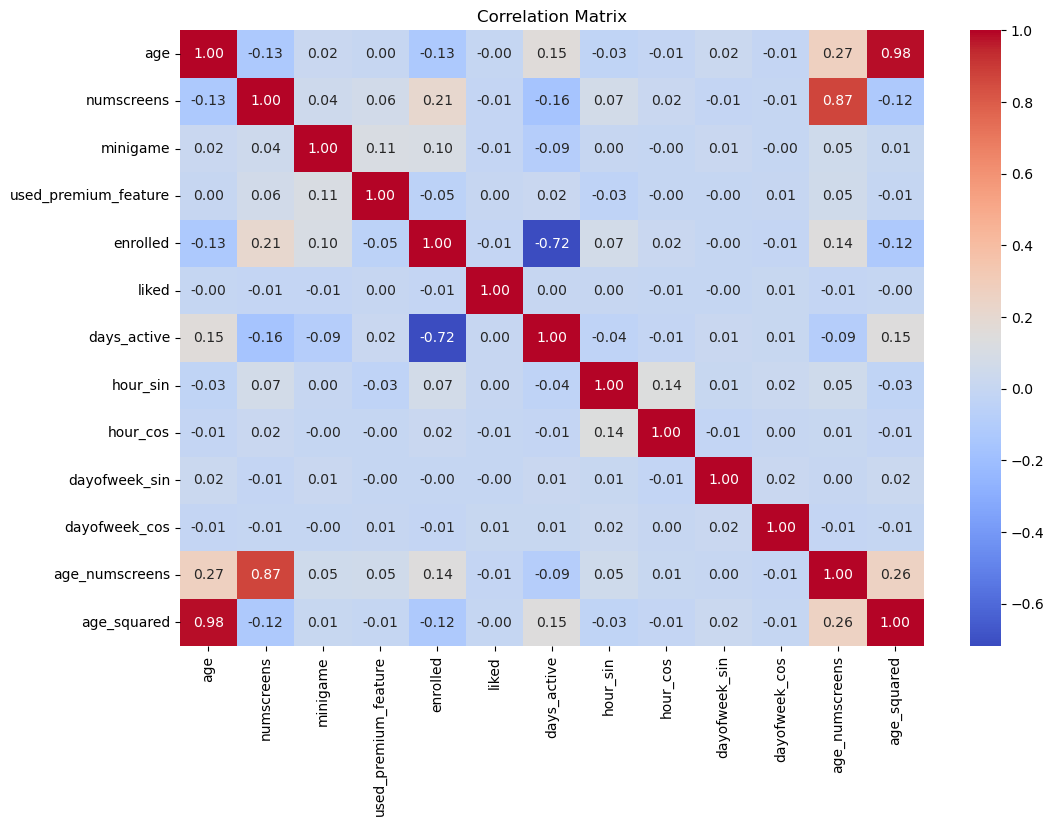

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

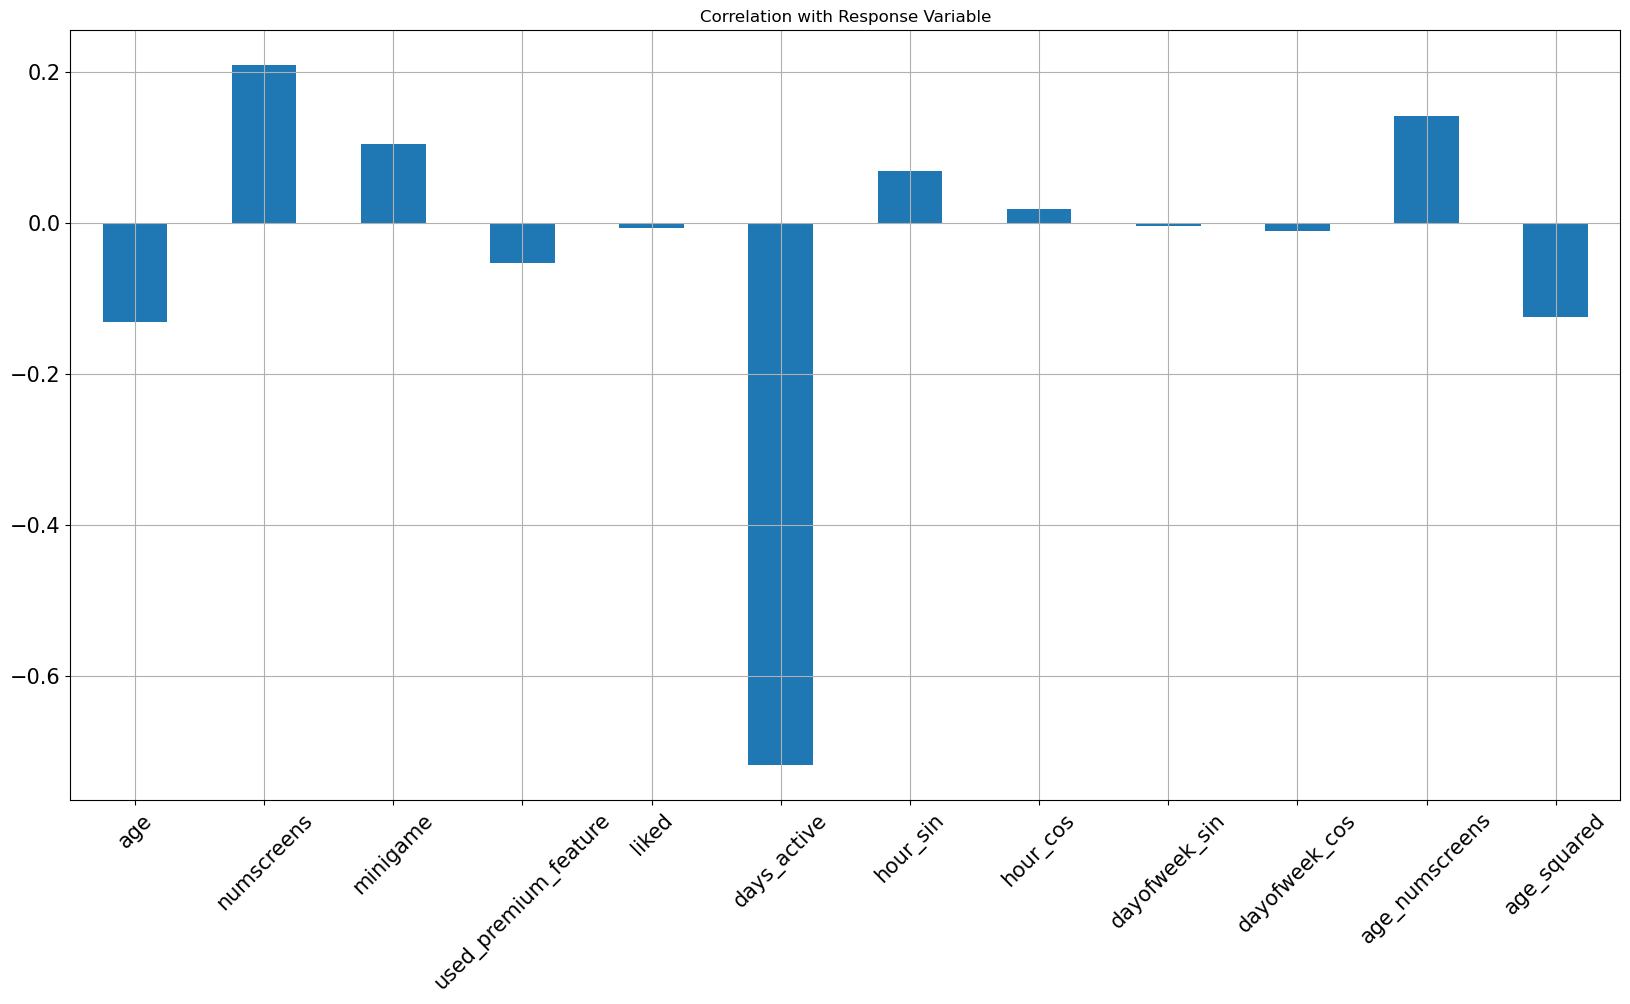

In [9]:
 # b. Bar Plot: Correlation of each feature with the response variable 'enrolled'
correlations = corr['enrolled'].drop('enrolled')
plt.figure(figsize=(20, 10))
correlations.plot.bar(title='Correlation with Response Variable', fontsize=15, rot=45, grid=True)
plt.show()

In [10]:
# Dropping weakly correlated features
drop_cols = ['hour_sin', 'hour_cos', 'dayofweek_sin']
df = df.drop(columns=drop_cols)

In [11]:
df.head()

,age,numscreens,minigame,used_premium_feature,enrolled,liked,days_active,dayofweek_cos,age_numscreens,age_squared
0,23,15,0,0,0,0,194,-0.900969,345,529
1,24,13,0,0,0,0,219,0.623490,312,576
2,23,3,0,1,0,1,111,0.623490,69,529
3,28,40,0,0,1,0,0,-0.900969,1120,784
4,31,32,0,0,1,1,0,0.623490,992,961


Overall Accuracy: 0.87


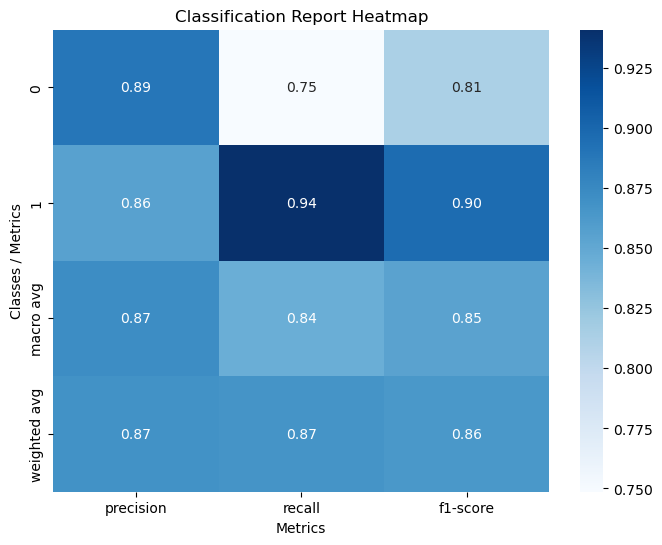

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Define the features to keep
features_to_keep = ['days_active', 'age_numscreens', 'numscreens', 'minigame', 'used_premium_feature']

# Apply feature selection on the entire dataset
X = df[features_to_keep]
y = df['enrolled']

# Now perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict probabilities and classes
y_scores = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

# Generate classification report as a dictionary
report_dict = classification_report(y_test, y_pred, output_dict=True)

# Print overall accuracy
accuracy = report_dict['accuracy']
print("Overall Accuracy: {:.2f}".format(accuracy))

# Convert the classification report to a DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Remove the 'accuracy' row from the DataFrame for the heatmap
if 'accuracy' in report_df.index:
    report_df = report_df.drop('accuracy')

# Plot the heatmap for precision, recall, and f1-score (excluding support)
plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:, :3], annot=True, cmap='Blues', fmt='.2f')
plt.title("Classification Report Heatmap")
plt.ylabel("Classes / Metrics")
plt.xlabel("Metrics")
plt.show()

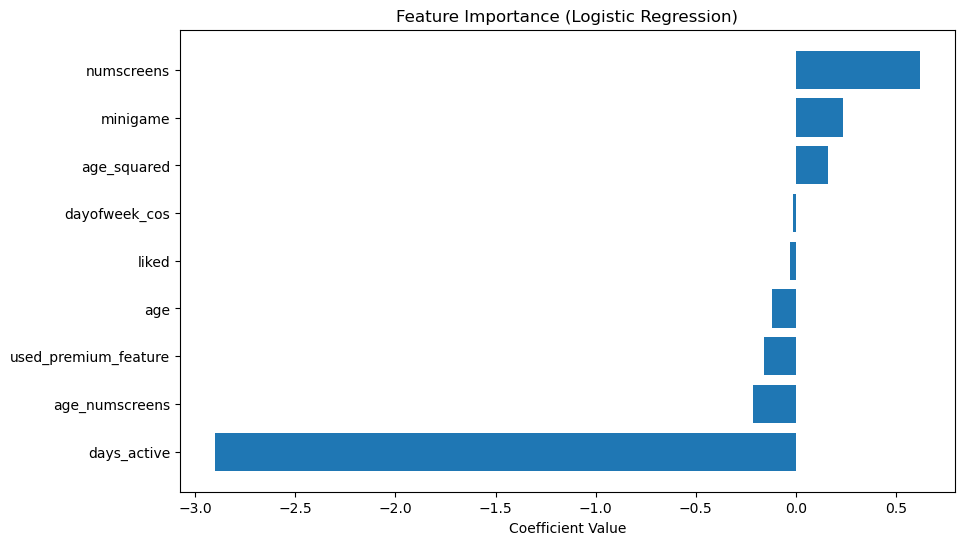

In [13]:
import pandas as pd
import numpy as np

# Extract feature importance
feature_importance = pd.DataFrame({'Feature': df.drop(columns=['enrolled']).columns, 'Coefficient': model.coef_[0]})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

# Plot feature importance
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Feature Importance (Logistic Regression)')
plt.gca().invert_yaxis()
plt.show()

In [14]:
df['enrolled'].value_counts(normalize=True)

enrolled
1    0.62148
0    0.37852
Name: proportion, dtype: float64

Overall Accuracy (XGBoost): 0.91


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:05:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


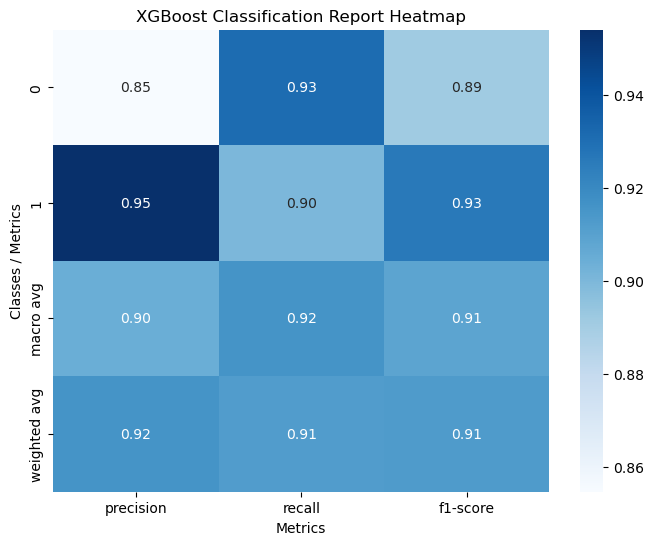

In [20]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Train XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)

# Generate classification report as a dictionary
report_dict = classification_report(y_test, y_pred_xgb, output_dict=True)

# Print overall accuracy
accuracy = report_dict['accuracy']
print("Overall Accuracy (XGBoost): {:.2f}".format(accuracy))

# Convert the classification report to a DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Remove the 'accuracy' row from the DataFrame for the heatmap
if 'accuracy' in report_df.index:
    report_df = report_df.drop('accuracy')

# Plot the heatmap for precision, recall, and f1-score (excluding support)
plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:, :3], annot=True, cmap='Blues', fmt='.2f')
plt.title("XGBoost Classification Report Heatmap")
plt.ylabel("Classes / Metrics")
plt.xlabel("Metrics")
plt.show()

Overall Accuracy (Random Forest): 0.90


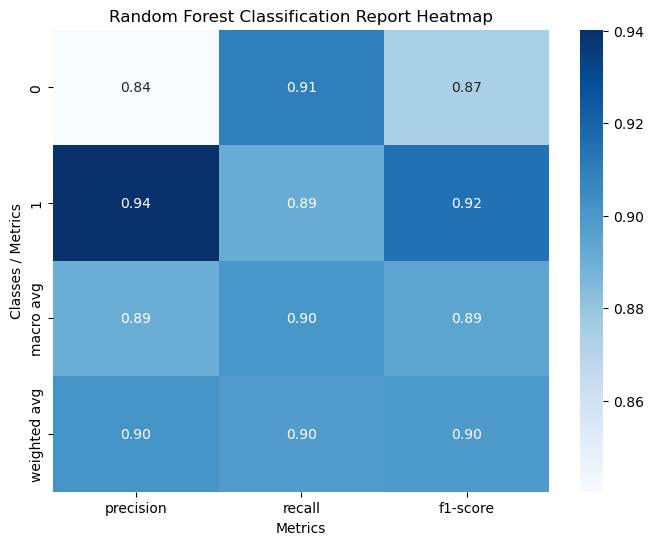

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Generate classification report as a dictionary
report_dict = classification_report(y_test, y_pred_rf, output_dict=True)

# Print overall accuracy
accuracy = report_dict['accuracy']
print("Overall Accuracy (Random Forest): {:.2f}".format(accuracy))

# Convert the classification report to a DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Remove the 'accuracy' row from the DataFrame for the heatmap
if 'accuracy' in report_df.index:
    report_df = report_df.drop('accuracy')

# Plot the heatmap for precision, recall, and f1-score (excluding support)
plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:, :3], annot=True, cmap='Blues', fmt='.2f')
plt.title("Random Forest Classification Report Heatmap")
plt.ylabel("Classes / Metrics")
plt.xlabel("Metrics")
plt.show()